In [15]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Flatten, Dense
import numpy as np
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import pandas as pd
import matplotlib.pyplot as plt

try:
    dataset = pd.read_excel('/home/fibonacci/Desktop/work/COVID-19 DATA.xlsx')
    column_headers = dataset.iloc[0]
    dataset.columns = column_headers
    dataset = dataset.drop([0])
    dataset['Date']=pd.to_datetime(dataset['Date'])
    dataset = dataset.iloc[:, 0:6]
    dataset.fillna(0, inplace=True)
except FileNotFoundError:
    print("Dataset file not found. Please make sure 'COVID-19 DATA.xlsx' exists.")

In [16]:
dataset.columns = dataset.columns.str.strip()

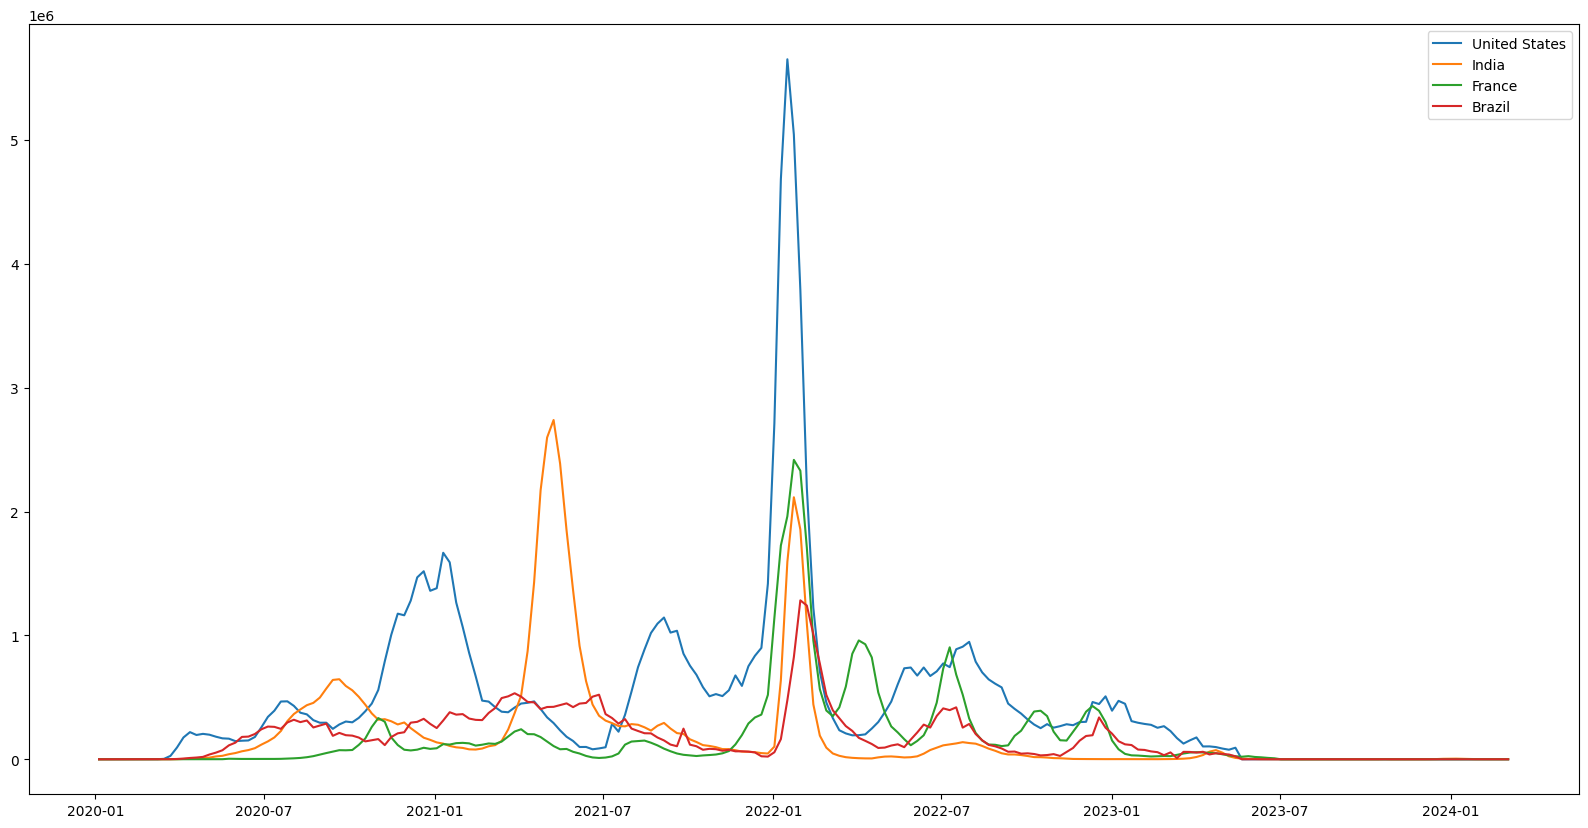

In [19]:
countries = ['United States', 'India', 'France','Brazil']
dataset = dataset[['Date'] + countries]
# Visualize the data for each country
plt.figure(figsize=(20, 10))
for country in countries:
    plt.plot(dataset['Date'], dataset[country], label=country)
plt.legend()
plt.show()

In [20]:
dataset.head()

,Date,United States,India,France,Brazil
1,2020-01-05,0,0,0,0
2,2020-01-12,0,0,0,0
3,2020-01-19,0,0,0,0
4,2020-01-26,7,0,3,0
5,2020-02-02,2,2,3,0


In [6]:
for country in countries:
    country_data = pd.DataFrame(list(dataset[country]), index=dataset['Date'], columns=[country])

Epoch 1/20
9/9 [==============================] - 8s 169ms/step - loss: 0.4501 - accuracy: 0.0000e+00 - val_loss: 0.3071 - val_accuracy: 0.0000e+00
Epoch 2/20
9/9 [==============================] - 1s 89ms/step - loss: 0.1535 - accuracy: 0.0000e+00 - val_loss: 0.1859 - val_accuracy: 0.0000e+00
Epoch 3/20
9/9 [==============================] - 1s 84ms/step - loss: 0.1157 - accuracy: 0.0000e+00 - val_loss: 0.0395 - val_accuracy: 0.0000e+00
Epoch 4/20
9/9 [==============================] - 1s 99ms/step - loss: 0.0935 - accuracy: 0.0000e+00 - val_loss: 0.0488 - val_accuracy: 0.0000e+00
Epoch 5/20
9/9 [==============================] - 1s 127ms/step - loss: 0.0905 - accuracy: 0.0000e+00 - val_loss: 0.0222 - val_accuracy: 0.0000e+00
Epoch 6/20
9/9 [==============================] - 1s 160ms/step - loss: 0.0964 - accuracy: 0.0000e+00 - val_loss: 0.0695 - val_accuracy: 0.0000e+00
Epoch 7/20
9/9 [==============================] - 1s 129ms/step - loss: 0.0865 - accuracy: 0.0000e+00 - val_loss: 0

Epoch 16/20
9/9 [==============================] - 1s 88ms/step - loss: 0.0647 - accuracy: 0.0000e+00 - val_loss: 0.0161 - val_accuracy: 0.0000e+00
Epoch 17/20
9/9 [==============================] - 1s 84ms/step - loss: 0.0667 - accuracy: 0.0000e+00 - val_loss: 0.0069 - val_accuracy: 0.0000e+00
Epoch 18/20
9/9 [==============================] - 1s 85ms/step - loss: 0.0508 - accuracy: 0.0000e+00 - val_loss: 0.0032 - val_accuracy: 0.0000e+00
Epoch 19/20
9/9 [==============================] - 1s 112ms/step - loss: 0.0399 - accuracy: 0.0000e+00 - val_loss: 0.0331 - val_accuracy: 0.0000e+00
Epoch 20/20
2/2 [==============================] - 1s 27ms/step
Epoch 1/20
9/9 [==============================] - 7s 185ms/step - loss: 0.3614 - accuracy: 0.0000e+00 - val_loss: 0.0078 - val_accuracy: 0.0000e+00
Epoch 2/20
9/9 [==============================] - 1s 82ms/step - loss: 0.1200 - accuracy: 0.0000e+00 - val_loss: 0.0917 - val_accuracy: 0.0000e+00
Epoch 3/20
9/9 [==============================] 

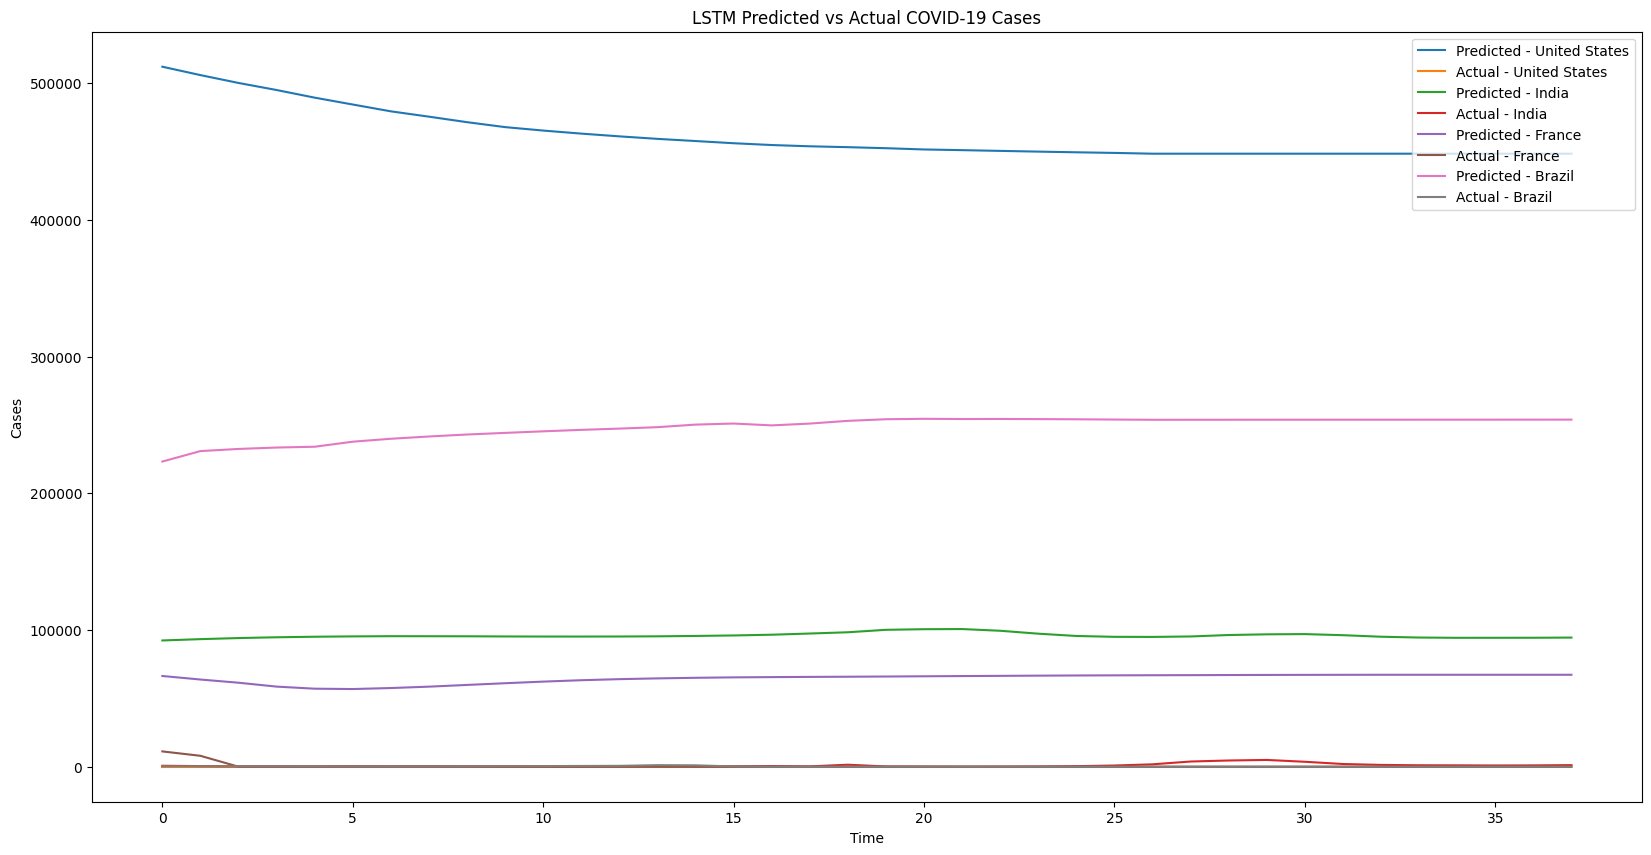

In [25]:
# Define the model architecture
def build_model(input_shape):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=input_shape))
    model.add(LSTM(128, activation='relu', return_sequences=True))
    model.add(LSTM(128, activation='relu', return_sequences=True))
    model.add(Bidirectional(LSTM(64, activation='relu')))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1))
    return model

# Preprocess, scale, sequence, train, and predict for each country
plt.figure(figsize=(20, 10)) 

# Loop through each country
for country in ['United States', 'India', 'France', 'Brazil']:
    # Prepare data for the specific country
    country_data = pd.DataFrame(list(dataset[country]), index=dataset['Date'], columns=[country])
    
    # Scale the data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_data = scaler.fit_transform(country_data)
    
    # Prepare input-output sequences
    steps = 30
    inputs = []
    outputs = []
    for i in range(len(scaled_data) - steps):
        inputs.append(scaled_data[i:i + steps])
        outputs.append(scaled_data[i + steps])

    inputs = np.asarray(inputs)
    outputs = np.asarray(outputs)
    x_train, x_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.2, shuffle=False)

    # Build and compile the model
    input_shape = (inputs.shape[1], inputs.shape[2])  # Shape of input sequence
    model = build_model(input_shape)
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

    # Train the model
    model.fit(x_train, y_train, epochs=20, batch_size=16, validation_split=0.1, verbose=1)

    # Make predictions
    predicted = model.predict(x_test)
    predicted = scaler.inverse_transform(predicted)
    y_test = scaler.inverse_transform(y_test)

    # Plot predicted vs. actual values for the current country
    plt.plot(predicted, label=f'Predicted - {country}')
    plt.plot(y_test, label=f'Actual - {country}')

# Set plot labels and legend
plt.xlabel('Time')
plt.ylabel('Cases')
plt.title('LSTM Predicted vs Actual COVID-19 Cases')
plt.legend()
plt.show()